<br/>

$$ \huge{\underline{\textbf{ Feature Construction for Linear Models }}} $$

<br/>

We are going to use Gradient MC algorithm from chapter 9.3 as a learning algorithm. Before continuing you should familiarise yourself properly with [chapter 9.3](0903a_Gradient_MC.ipynb). We will use the "fixed" version of Gradient MC, repeated here for reference.

One notable difference is that this version takes callback and trace arguments, so we can log results after each episode. This is used to reproduce figures in the book.

In [1]:
def gradient_MC(env, policy, ep, gamma, model, callback=None, trace=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
        callback - function in a form: callback(episode, model, trace) -> None
        trace  - passed to callback, so it can log data into it
    """
    for e_ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)
               
        if callback is not None:
            callback(e_, model, trace)

In [2]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0905.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 9.5 - added noise due to reduced nb of runs to 3 from 30 in the book<center/></td>
    </tr>
</table>

# Environment Setup

All environment and plotting code is exactly the same as in [chapter 9.3](0903a_Gradient_MC.ipynb). All the code is available here: [helpers_0905.py](helpers_0905.py)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from helpers_0905 import LinearEnv, plot_linear

In [4]:
env = LinearEnv()

In [5]:
def policy(st):
    return np.random.choice([0, 1])

# Polynomial Basis

In [chapter 9.3](0903a_Gradient_MC.ipynb) we approximated state value function by grouping 1000 states into 10 groups, each group with its own value. Here we will implement drop-in replacement for that approximator that will fit polynomial instead. Actually, as we will soon see, all approximators in this chapter are compatible drop-in replacements.

Box from the book as reference.

<img src="assets/0905_Poly_Basis.png"/>
<center>Polynomial Basis - from Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 9.5.1</center>

In [6]:
class PolynomialFuncApprox():
    """Polynomial function approximator"""
    def __init__(self, learn_rate, order, nb_states):
        self._lr = learn_rate
        self._order = order
        self._nb_states = nb_states
        self._w = np.zeros(order+1)                    # weights
        
    def evaluate(self, state):
        st01 = state / self._nb_states                 # map to 0..1
        x = np.power(st01, range(self._order+1))       # x = [st**0, st**1, ..., st**order]
        return x @ self._w                             # linear combination, i.e. dot product

    def train(self, state, target):
        st01 = state / self._nb_states                 # map to 0..1
        x = np.power(st01, range(self._order+1))       # x = [st**0, st**1, ..., st**order]
        grad = x                                       # grad. of lin. comb. is input x
        
        v_hat = self.evaluate(state)
        self._w += self._lr * (target - v_hat) * grad  # Gradient MC update, see chapt. 9.3

### Polynomial Basis Test

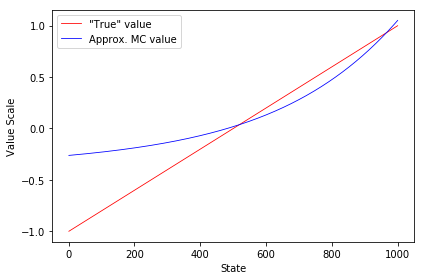

In [7]:
model = PolynomialFuncApprox(learn_rate=0.0001, order=5, nb_states=1000)
gradient_MC(env, policy, ep=1000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env)

# Fourier Basis

<img src="assets/0905_Fourier_Basis.png"/>
<center>Fourier Basis - both from Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 9.5.2 </center>

In [8]:
class FourierFuncApprox():
    """Polynomial function approximator"""
    def __init__(self, learn_rate, order, nb_states):
        self._lr = learn_rate
        self._order = order
        self._nb_states = nb_states
        self._w = np.zeros(order+1)                    # weights
        
    def evaluate(self, state):
        st01 = state / self._nb_states                 # map to 0..1
        c_i = np.arange(self._order+1)
        x = np.cos(np.pi * st01 * c_i)                 # x = [cos(pi*st*0), cos(pi*st*1), ...]
        return x @ self._w                             # linear combination, i.e. dot product
    

    def train(self, state, target):
        st01 = state / self._nb_states                 # map to 0..1
        c_i = np.arange(self._order+1)
        x = np.cos(np.pi * st01 * c_i)                 # x = [cos(pi*st*0), cos(pi*st*1), ...]
        grad = x                                       # grad. of lin. comb. is just x
        
        v_hat = self.evaluate(state)
        self._w += self._lr * (target - v_hat) * grad  # Gradient MC update, see chapt. 9.3

### Fourier Basis Test

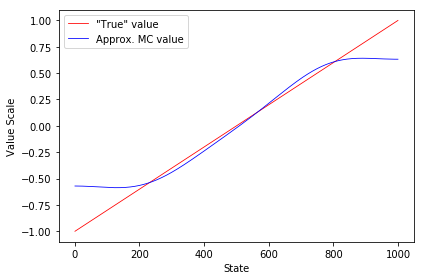

In [10]:
model = FourierFuncApprox(learn_rate=0.0001, order=5, nb_states=1000)
gradient_MC(env, policy, ep=1000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env)

# Recreate Figure 9.5

Callback is called by *gradient_MC* every single timestep:
* compute V for all states
* compute Root Mean Squared Error (skip terminal state 0, state 1001 is out of boundry)
* append to *rmse* list

In [11]:
def callback(episode, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    V = np.array([model.evaluate(st) for st in range(1001)])                   # arr of float
    err = np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))  # float
    trace.append(err)

Define experiment

In [12]:
def experiment(runs, env, policy, ep, gamma, model, callback):
    results = []  # dims: [nb_runs, nb_episodes]
    for r in range(runs):
        trace = []  # dim: [nb_episodes]
        gradient_MC(env, policy, ep, gamma, model, callback=callback, trace=trace)
        results.append(trace)
    return np.average(results, axis=0)

Compute RMSE for polynomial approximator. This may take 5+ minutes.

In [13]:
model = PolynomialFuncApprox(learn_rate=0.0001, order=5, nb_states=1000)
poly_order_5 = experiment(3, env, policy, ep=5000, gamma=1.0, model=model, callback=callback)

And the Fourier approximator. This may take 5+ minutes.

In [14]:
model = FourierFuncApprox(learn_rate=0.00005, order=5, nb_states=1000)
fourier_order_5 = experiment(3, env, policy, ep=5000, gamma=1.0, model=model, callback=callback)

Plot results

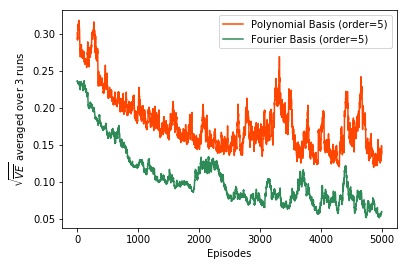

In [496]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(poly_order_5, color='orangered', label='Polynomial Basis (order=5)')
ax.plot(fourier_order_5, color='seagreen', label='Fourier Basis (order=5)')
ax.set_ylabel('$\sqrt{\overline{VE}}$ averaged over 3 runs')
ax.set_xlabel('Episodes')
# plt.savefig('assets/fig_0905.png')
ax.legend()
plt.show()